In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud as wc

from string import punctuation as p, digits as d
from collections import Counter as cnt
from nltk.tokenize import word_tokenize as wt
from nltk.stem import WordNetLemmatizer as wl
from nltk.corpus import stopwords
from gensim import corpora

from sklearn.feature_extraction.text import TfidfVectorizer as tf
from sklearn.model_selection import train_test_split as tts,GridSearchCV as gsv,cross_val_score as cvs

from sklearn.metrics import accuracy_score,classification_report,f1_score,auc,roc_curve,roc_auc_score,confusion_matrix,log_loss,\
precision_score,recall_score,mean_squared_error

from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from  sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import joblib

In [2]:
df=pd.read_csv("C://Users//ABHISHEK//CSV//train_news.csv")

In [3]:
df.head(7)

,Unnamed: 0,id,headline,written_by,news,label
0,0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1
5,5,3196,Whatever the Outcome on November 8th the US Wi...,NaN,Taming the corporate media beast Whatever the ...,1
6,6,5134,Rapid Evolution Saved This Fish From Pollution...,JoAnna Klein,The State of New Jersey says you can’t eat the...,0


In [4]:
print('Shape of the dataset -\n ',df.shape)

print('\nName of columns in the dataset-\n',df.columns.values)

Shape of the dataset -
  (20800, 6)

Name of columns in the dataset-
 ['Unnamed: 0' 'id' 'headline' 'written_by' 'news' 'label']


In [5]:
#checking if there is any duplicated values
print('Number of duplicated values:-',df.duplicated().sum())

Number of duplicated values:- 0


In [6]:
#checking for null values
for i in df.columns:
    null=df[i].isnull().sum()
    if null>0:
        print('Number of Null Values At Column ',i ,'==  ',null )
    else:
        print('There are no null values in column-',i)

There are no null values in column- Unnamed: 0
There are no null values in column- id
Number of Null Values At Column  headline ==   558
Number of Null Values At Column  written_by ==   1957
Number of Null Values At Column  news ==   39
There are no null values in column- label


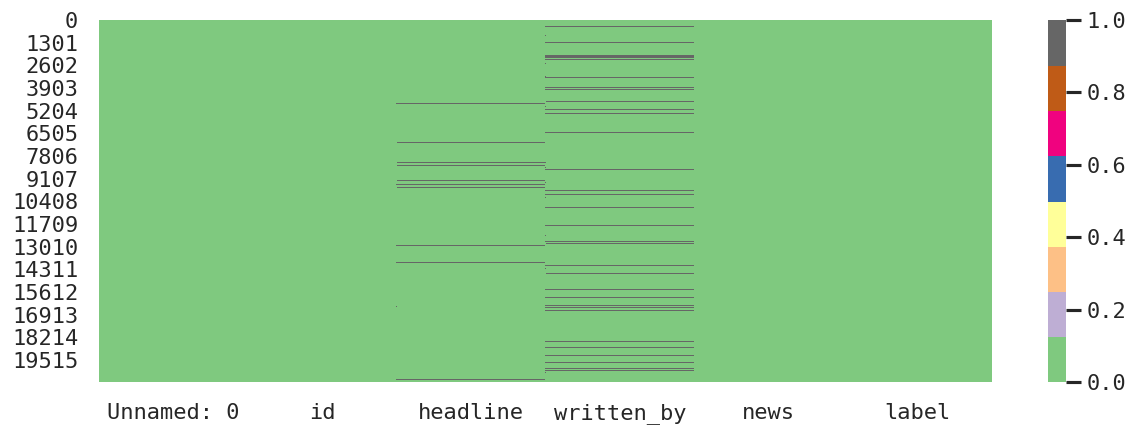

In [7]:
#heatmap of null values
sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=0.8)
plt.figure(figsize=(12,4),dpi=120)
sns.heatmap(df.isnull(),cmap='Accent')
plt.show()

In [8]:
#dropping unwanted columns as we'll be working on the news and labe columns only
#dropping null values

news=df.copy()
news.dropna(inplace=True)
news.drop(['Unnamed: 0','id','headline','written_by'],axis=1,inplace=True)
news.reset_index(inplace=True)


In [9]:
news['len of uncleaned news']= news['news'].str.len().astype('int64')
news.head(7)

,index,news,label,len of uncleaned news
0,0,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,7936
1,1,HOUSTON — Venezuela had a plan. It was a ta...,0,6112
2,2,"Sunday on ABC’s “This Week,” while discussing ...",0,425
3,3,"AUGUSTA, Me. — The beleaguered Republican g...",0,6516
4,4,Finian Cunningham has written extensively on...,1,9164
5,6,The State of New Jersey says you can’t eat the...,0,4159
6,7,Advocates say prison officials at the Kilby Co...,1,6311


In [10]:
#checking data loss percentage
print('shape of the dataset with null values: ',df.shape)
print('Shape of dataset without any null vallues: ', news.shape)
print('No of rows dropped:', df.shape[0]-news.shape[0])
print('Percentage dropped:',((df.shape[0]-news.shape[0])/df.shape[0])*100)

shape of the dataset with null values:  (20800, 6)
Shape of dataset without any null vallues:  (18285, 4)
No of rows dropped: 2515
Percentage dropped: 12.091346153846153


In [11]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18285 entries, 0 to 18284
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   index                  18285 non-null  int64 
 1   news                   18285 non-null  object
 2   label                  18285 non-null  int64 
 3   len of uncleaned news  18285 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 571.5+ KB


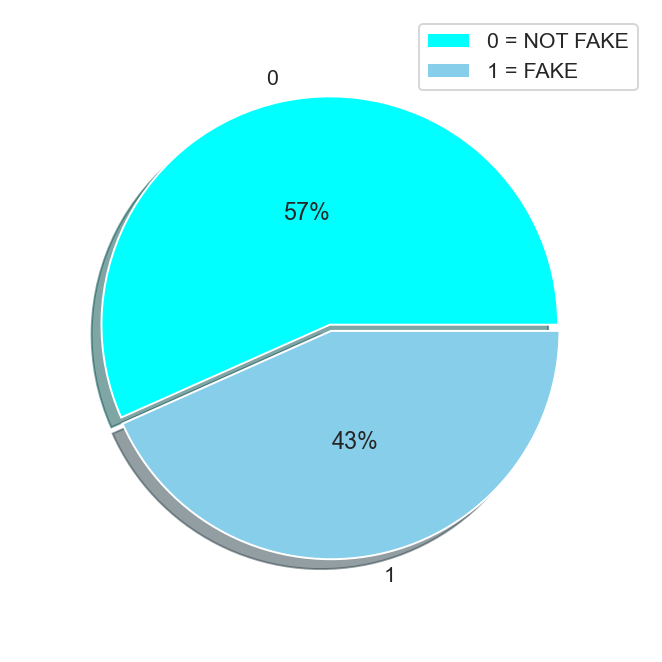

In [12]:
lb=news['label'].value_counts().index.tolist()
val=news['label'].value_counts().values.tolist()
exp=(0.025,0)
clr=('cyan','skyblue')
plt.figure(figsize=(10,6),dpi=140)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
plt.pie(x=val,explode=exp,labels=lb,colors=clr,autopct='%2.0f%%',pctdistance=0.5, shadow=True,radius=0.9)
plt.legend(["0 = NOT FAKE",'1 = FAKE'])
plt.show()

In [13]:
#CREATING A FUNCTION TO PERFORM ASERIES OF OPERATIONS

def preprocess(text):
    processed=[]
    lower=text.lower().replace(r'\n'," ").replace(r'\s+', ' ').replace(r'\d+(\.\d+)?', ' ')
    text=lower.replace(r"[^a-zA-Z0-9]+", " ").replace(r"—"," ").replace(r'“', ' ').replace(r'”',' ').replace('’',' ').replace(r'–',' ')
    #removing \n,large white space and leading_trailing white spaces, numbers and special characters by single white space
    
    punct=text.translate(str.maketrans('', '', p))  #remove punctuation
    digit=punct.translate(str.maketrans('', '', d))       #remove digits if any
    word= wt(digit, "english")
    
    for i in word:
        if i not in stopwords.words('english'):
            lemma=wl().lemmatize(i)
            processed.append(lemma)
    return (" ".join([x for x in processed])).strip()

In [14]:
#TESTING THE FUNCTION CREATED ABOVE
text = 'A power-packed top order consisting of players such as Shikhar Dhawan, Prithvi Shaw, Shreyas Iyer and Rishabh Pant, meant that \
the Aussie was tried out in the middle-order, and more often than not, he showed the class that he belongs to.\
Delhi Capitals coach Ricky Ponting knows a fair bit about Stoinis. Besides coaching him at the IPL franchise, he was also the coach of \
Australia in the ICC ODI World Cup of 2019, and Stoinis was in the squad.\
But the Stoinis that we got to see at the World Cup, where a side injury and a loss of form took over him, was not half the player that he is\
now. In fact, going by Ponting’s words Stoinis right now is five times better player than he was 12 months ago.\
"From the moment he turned up at the IPL, having come straight from England he was pretty keen to show me improvements that he\'d \
made. And his first few net sessions, I could just tell then, Ponting was quoted as saying by cricket.com.au\
Having spent a fair bit of time with him over the past couple of years, what I saw from him at the IPL suggests to me that he\'s a five times \
better player than he was 12 months ago, the Australia legend added..'
print("Original Document: \n",text)


processed=[]

for word in text.split(' '):
    processed.append(word)
print(processed)

print("\n\nTokenized and lemmatized document: \n")
print(preprocess(text))

Original Document: 
 A power-packed top order consisting of players such as Shikhar Dhawan, Prithvi Shaw, Shreyas Iyer and Rishabh Pant, meant that the Aussie was tried out in the middle-order, and more often than not, he showed the class that he belongs to.Delhi Capitals coach Ricky Ponting knows a fair bit about Stoinis. Besides coaching him at the IPL franchise, he was also the coach of Australia in the ICC ODI World Cup of 2019, and Stoinis was in the squad.But the Stoinis that we got to see at the World Cup, where a side injury and a loss of form took over him, was not half the player that he isnow. In fact, going by Ponting’s words Stoinis right now is five times better player than he was 12 months ago."From the moment he turned up at the IPL, having come straight from England he was pretty keen to show me improvements that he'd made. And his first few net sessions, I could just tell then, Ponting was quoted as saying by cricket.com.auHaving spent a fair bit of time with him over

In [15]:
news['news'][7]

'Leave a reply \nToni Emerson – When we fall in love, our heart becomes full of feel-good qualities that infuse our life with joy and excitement. Everything feels light, fresh and more vibrant. We wake up to a brighter day, the air is warmer, the sun is brighter, everything is right with the world. \nLiving life through the interactive and colorful kaleidoscope of love is one of the highest human experiences . Wouldn’t it be fantastic to capture this experience and transform it into a permanent state of being? In my next few articles, we will formulate our unique blueprint to reconnect to our love source and transition from experiences of love which come and go to living love at its fullest moment to moment. Love & Emotions \nUnderstanding the difference between love and the many feelings inspired by love is essential in realizing that love is the baseline from which everything else emerges. \nAs human beings, we experience many emotional states under love’s vast umbrella, yet each one

In [16]:
%%time
clean = []

for i in news['news']:
    clean.append(preprocess(i))

Wall time: 44min 47s


In [17]:
print("Length of cleaned text=\t",len(clean))
print(clean[7])

Length of cleaned text=	 18285
leave reply toni emerson fall love heart becomes full feelgood quality infuse life joy excitement everything feel light fresh vibrant wake brighter day air warmer sun brighter everything right world living life interactive colorful kaleidoscope love one highest human experience fantastic capture experience transform permanent state next article formulate unique blueprint reconnect love source transition experience love come go living love fullest moment moment love emotion understanding difference love many feeling inspired love essential realizing love baseline everything else emerges human being experience many emotional state love vast umbrella yet one fails convey totality love love equal sum part far powerful transient emotion integral state waiting rediscovered deeply nourishing emotion ushered love stand merit offer specific gift emotion assist u reaching full potential human deepening interior faculty also giving u human quality propel u action he

In [18]:
#USING THE EXTRACTED FEATURE AS news
processed = pd.DataFrame({'cleaned news' : clean })
news['clean_news']= processed

In [19]:
news['len of cleaned news']=news['clean_news'].str.len().astype('int64')
news.head(5)

,index,news,label,len of uncleaned news,clean_news,len of cleaned news
0,0,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,7936,washington sonny perdue telling georgian growi...,5246
1,1,HOUSTON — Venezuela had a plan. It was a ta...,0,6112,houston venezuela plan tactical approach desig...,3947
2,2,"Sunday on ABC’s “This Week,” while discussing ...",0,425,sunday abc week discussing republican plan rep...,259
3,3,"AUGUSTA, Me. — The beleaguered Republican g...",0,6516,augusta beleaguered republican governor maine ...,4327
4,4,Finian Cunningham has written extensively on...,1,9164,finian cunningham written extensively internat...,6515


In [20]:
print('Original Length = ',news['len of uncleaned news'].sum())
print('Clean Length =  ', news['len of cleaned news'].sum())
print('Total Reduction = ',news['len of uncleaned news'].sum()-news['len of cleaned news'].sum())

Original Length =  87771325
Clean Length =   58426659
Total Reduction =  29344666


## MODELLING

In [21]:
news.head(10)

,index,news,label,len of uncleaned news,clean_news,len of cleaned news
0,0,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,7936,washington sonny perdue telling georgian growi...,5246
1,1,HOUSTON — Venezuela had a plan. It was a ta...,0,6112,houston venezuela plan tactical approach desig...,3947
2,2,"Sunday on ABC’s “This Week,” while discussing ...",0,425,sunday abc week discussing republican plan rep...,259
3,3,"AUGUSTA, Me. — The beleaguered Republican g...",0,6516,augusta beleaguered republican governor maine ...,4327
4,4,Finian Cunningham has written extensively on...,1,9164,finian cunningham written extensively internat...,6515
5,6,The State of New Jersey says you can’t eat the...,0,4159,state new jersey say eat fish shellfish lower ...,2752
6,7,Advocates say prison officials at the Kilby Co...,1,6311,advocate say prison official kilby correctiona...,3945
7,9,Leave a reply \nToni Emerson – When we fall in...,1,6386,leave reply toni emerson fall love heart becom...,4239
8,10,BREAKING: Clinton Fixer Reveals Sick Smear Hil...,1,1664,breaking clinton fixer reveals sick smear hill...,1023
9,11,Home › POLITICS | US NEWS › BLOOMBERG-BACKED P...,1,2487,home › politics u news › bloombergbacked penns...,1836


In [22]:
X=news['clean_news']
y=news['label']

In [23]:
tfidf=tf(input='content', encoding='utf-8', lowercase=True,stop_words='english',max_features=7000,ngram_range=(1,3))

In [24]:
x=tfidf.fit_transform(X).toarray()

In [25]:
y=np.array(y)
y=y.reshape(-1,1)

In [26]:
print('shape of x:',x.shape,'\nshape of y:',y.shape)

shape of x: (18285, 7000) 
shape of y: (18285, 1)


In [27]:
#CHECKING THE SELECTED FEATURE NAMES
tfidf.get_feature_names()[1:30]

['abandon',
 'abandoned',
 'abc',
 'abc news',
 'abe',
 'abedin',
 'ability',
 'able',
 'aboard',
 'abortion',
 'abroad',
 'absence',
 'absolute',
 'absolutely',
 'absurd',
 'abu',
 'abuse',
 'abused',
 'academic',
 'academy',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'accepting',
 'access',
 'access pipeline',
 'accessible',
 'accident']

In [28]:
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]

def acusr(model,x,y):
    max_ac_score=0
    for rst in range(25,180):
        x_train,x_test,y_train,y_test=tts(x,y,test_size=0.30,random_state=rst)
        model.fit(x_train,y_train)
        pred=model.predict(x_test)
        f1=f1_score(pred,y_test)
        acc=accuracy_score(pred,y_test)
        clr=classification_report(y_test,pred)
        conf=confusion_matrix(y_test,pred)
        pre=precision_score(y_test,pred)
        rec=recall_score(y_test,pred)
        mse=mean_squared_error(y_test,pred)
        rmse=np.sqrt(mse)
        auc_scr=roc_auc_score(y_test,pred)
        tpr,fpr,threshold=roc_curve(y_test,pred)
        log = log_loss( y_test,pred)
    
        if acc>max_ac_score:
            max_ac_score=acc
            final_rst=rst
    print("In this",model,'\n\nThe best suited RANDOM SCORE=',final_rst, '\n\nACCURACY SCORE:', max_ac_score)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nCONFUSION MATRIX:\n',conf)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    print('\nLOG_LOSS:',log)
    
    ACCURACY.append(max_ac_score)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
    
#plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(10,6),dpi=100)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=15)
    plt.ylabel('FPR',weight='bold',fontsize=15)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=18,weight='bold',loc='center')
    plt.show()
    
    #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(12,7))
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()

## LOGISTIC REGRESSION

In this LogisticRegression() 

The best suited RANDOM SCORE= 106 

ACCURACY SCORE: 0.9498724024790376

F1 score: 0.9390787518573551

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      3118
           1       0.94      0.93      0.94      2368

    accuracy                           0.95      5486
   macro avg       0.95      0.95      0.95      5486
weighted avg       0.95      0.95      0.95      5486


CONFUSION MATRIX:
 [[2987  131]
 [ 156 2212]]

PRECISION:
 0.9440887750746906

RECALL:
 0.9341216216216216

MEAN SQUARED ERROR:
 0.052314983594604444

ROOT MEAN SQ. ERROR:
 0.22872468951690467

AUC_ROC Score:
 0.9460537550058075

TPR: [0.         0.04201411 1.        ] 
FPR: [0.         0.93412162 1.        ]

LOG_LOSS: 1.8069146140362244


	____________________________________________ROC_AUC CURVE_______________________________________________



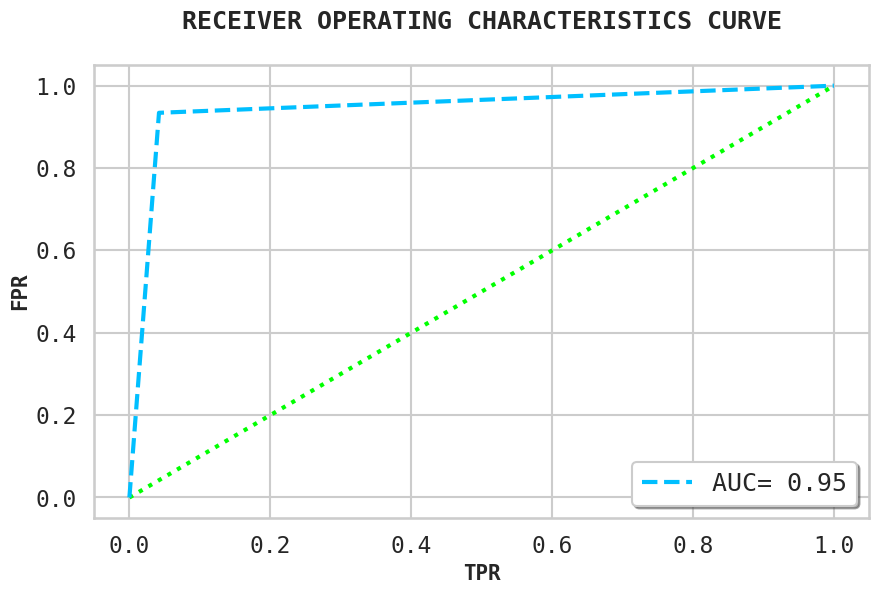



	____________________________________________CONFUSION MATRIX___________________________________________



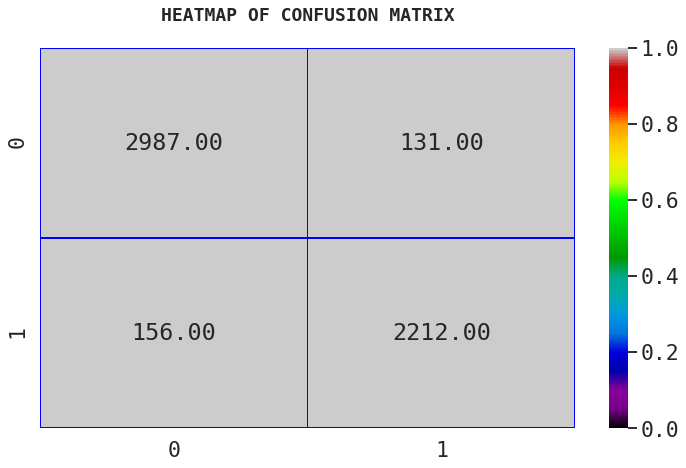

In [29]:
logi=LogisticRegression()
acusr(logi,x,y)

In [30]:
#using cross_val_score to check for over/under fitting of  LOGISTIC REGRESSION
logi_accuracy=cvs(logi,x,y,scoring='f1',cv=80)
print('THE F1 SCORE AT LOGISTIC MODEL IS=', logi_accuracy.mean())
CV_ACC.append(logi_accuracy.mean())

THE F1 SCORE AT LOGISTIC MODEL IS= 0.9394844811936405


## PASSIVE AGGRESSIVE CLASSIFIER

In [31]:
pac=PassiveAggressiveClassifier()
pac_para={'max_iter': [1000,1100,1200,1500]}
pac_gs=gsv(pac,pac_para,cv=90,n_jobs=-1)
pac_gs.fit(x,y)
print(pac_gs,'\n')
print(pac_gs.best_score_,'\n')
print(pac_gs.best_params_)

GridSearchCV(cv=90, estimator=PassiveAggressiveClassifier(), n_jobs=-1,
             param_grid={'max_iter': [1000, 1100, 1200, 1500]}) 

0.950721744636552 

{'max_iter': 1200}


In this PassiveAggressiveClassifier(max_iter=1200) 

The best suited RANDOM SCORE= 63 

ACCURACY SCORE: 0.953700328107911

F1 score: 0.9448058761804825

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      3118
           1       0.94      0.95      0.94      2368

    accuracy                           0.95      5486
   macro avg       0.95      0.95      0.95      5486
weighted avg       0.95      0.95      0.95      5486


CONFUSION MATRIX:
 [[2972  146]
 [ 117 2251]]

PRECISION:
 0.9390905298289528

RECALL:
 0.9505912162162162

MEAN SQUARED ERROR:
 0.047940211447320455

ROOT MEAN SQ. ERROR:
 0.21895253240673068

AUC_ROC Score:
 0.9518831642338298

TPR: [0.         0.04682489 1.        ] 
FPR: [0.         0.95059122 1.        ]

LOG_LOSS: 1.6558175233478534


	____________________________________________ROC_AUC CURVE_______________________________________________



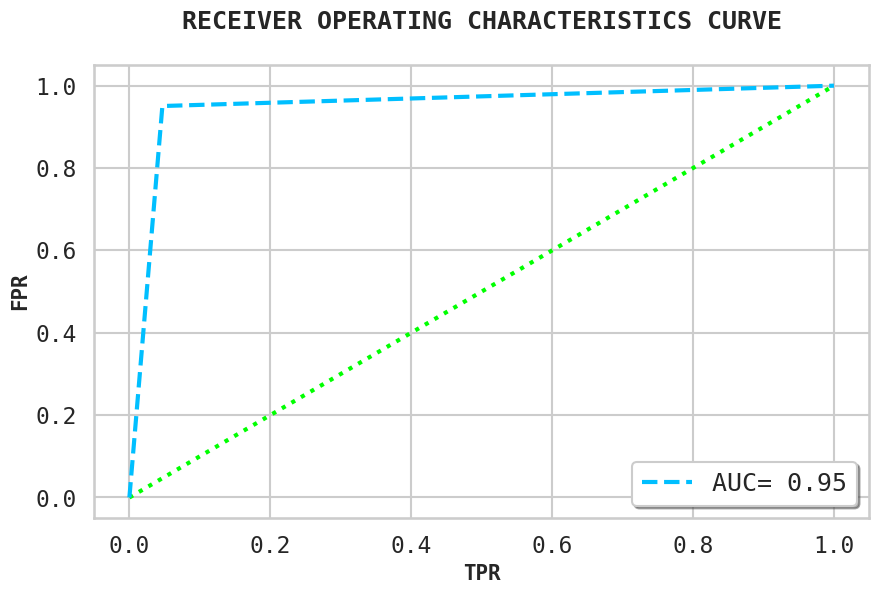



	____________________________________________CONFUSION MATRIX___________________________________________



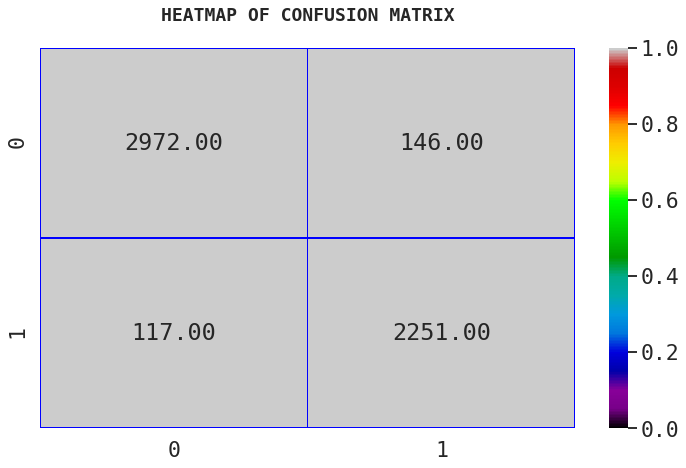

In [32]:
pac=PassiveAggressiveClassifier(max_iter=1200)
acusr(pac,x,y)

In [33]:
#using cross_val_score to check for over/under fitting of PASSIVE AGGRESIVE CLASSIFIER
pac_accuracy=cvs(pac,x,y,scoring='f1',cv=80)
print('THE F1 SCORE AT PASSIVE AGGRESIVE CLASSIFIER MODEL IS=', pac_accuracy.mean())
CV_ACC.append(pac_accuracy.mean())

THE F1 SCORE AT PASSIVE AGGRESIVE CLASSIFIER MODEL IS= 0.942896579256572


## MULTINOMIAL NB

In [34]:
nb=MultinomialNB()
params = {'alpha': [0.1, 0.2, 0.8, 0.9, 1.0]}
mnb = gsv(nb,params,scoring='f1_weighted', cv=50)
mnb.fit(x,y)
print(mnb)
print('\nbest_score=',mnb.best_score_)
print('\nbest_parameters=',mnb.best_params_)

GridSearchCV(cv=50, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.2, 0.8, 0.9, 1.0]},
             scoring='f1_weighted')

best_score= 0.9015971529065454

best_parameters= {'alpha': 0.1}


In this MultinomialNB(alpha=0.1) 

The best suited RANDOM SCORE= 170 

ACCURACY SCORE: 0.9104994531534816

F1 score: 0.8844621513944222

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      3118
           1       0.93      0.84      0.88      2368

    accuracy                           0.90      5486
   macro avg       0.91      0.90      0.90      5486
weighted avg       0.91      0.90      0.90      5486


CONFUSION MATRIX:
 [[2966  152]
 [ 370 1998]]

PRECISION:
 0.9293023255813954

RECALL:
 0.84375

MEAN SQUARED ERROR:
 0.09515129420342691

ROOT MEAN SQ. ERROR:
 0.30846603411628143

AUC_ROC Score:
 0.8975004008980115

TPR: [0.        0.0487492 1.       ] 
FPR: [0.      0.84375 1.     ]

LOG_LOSS: 3.286431428536779


	____________________________________________ROC_AUC CURVE_______________________________________________



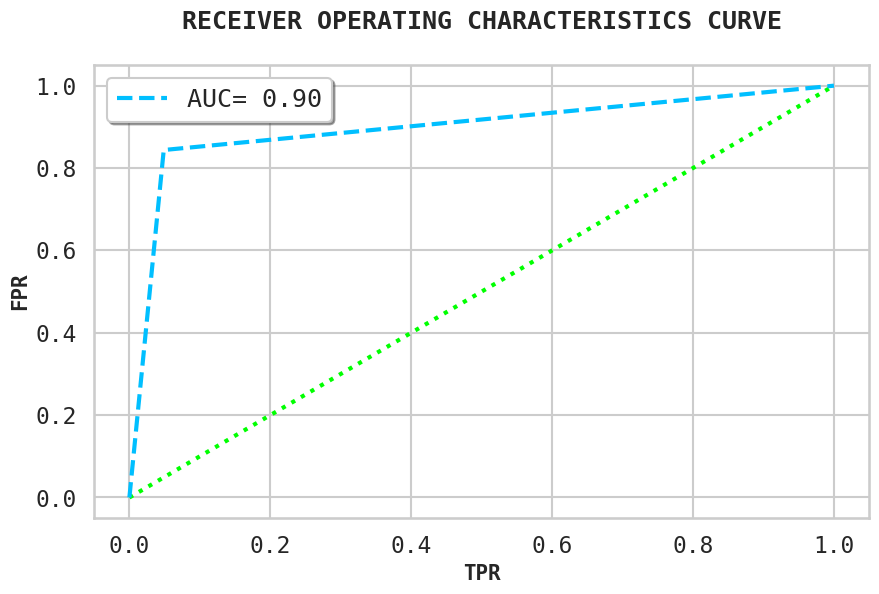



	____________________________________________CONFUSION MATRIX___________________________________________



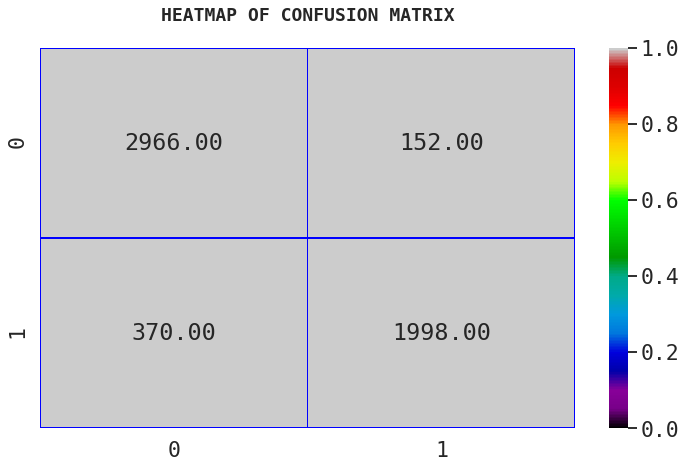

In [35]:
nb=MultinomialNB(alpha=0.1)
acusr(nb,x,y)

In [36]:
#using cross_val_score to check for over/under fitting of MULTINOMIAL NB
nb_accuracy=cvs(nb,x,y,scoring='f1',cv=80)
print('THE F1 SCORE AT MULTINOMIAL NB MODEL IS=', nb_accuracy.mean())
CV_ACC.append(nb_accuracy.mean())

THE F1 SCORE AT MULTINOMIAL NB MODEL IS= 0.8811832461661282


## COMPLEMENT NB

In [37]:
NB_Params = {'alpha': [0.1,  0.9, 1.0]}

cnb = ComplementNB()
cnb_gsv = gsv(cnb, NB_Params, cv=20)
cnb_gsv.fit(x,y)
print(cnb_gsv)
print('\nbest_score=',cnb_gsv.best_score_)
print('\nbest_parameters=',cnb_gsv.best_params_)

GridSearchCV(cv=20, estimator=ComplementNB(),
             param_grid={'alpha': [0.1, 0.9, 1.0]})

best_score= 0.90817926367017

best_parameters= {'alpha': 0.1}


In this ComplementNB(alpha=0.1) 

The best suited RANDOM SCORE= 176 

ACCURACY SCORE: 0.915056507473569

F1 score: 0.8932414980628497

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      3118
           1       0.91      0.88      0.89      2368

    accuracy                           0.91      5486
   macro avg       0.91      0.91      0.91      5486
weighted avg       0.91      0.91      0.91      5486


CONFUSION MATRIX:
 [[2915  203]
 [ 293 2075]]

PRECISION:
 0.9108867427568043

RECALL:
 0.8762668918918919

MEAN SQUARED ERROR:
 0.09041195771053591

ROOT MEAN SQ. ERROR:
 0.3006858122867388

AUC_ROC Score:
 0.9055805274084219

TPR: [0.         0.06510584 1.        ] 
FPR: [0.         0.87626689 1.        ]

LOG_LOSS: 3.122747978518781


	____________________________________________ROC_AUC CURVE_______________________________________________



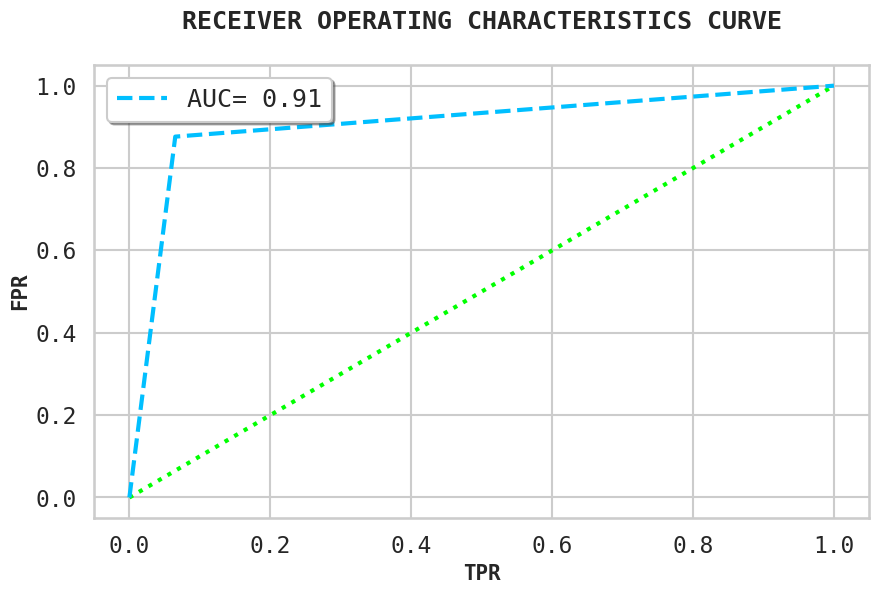



	____________________________________________CONFUSION MATRIX___________________________________________



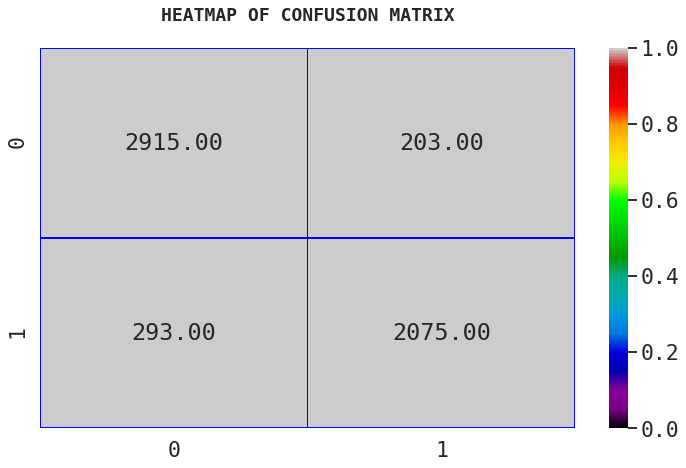

In [38]:
cnb = ComplementNB(alpha=0.1)
acusr(cnb,x,y)

In [39]:
#using cross_val_score to check for over/under fitting of COMPLEMENT NB
cnb_accuracy=cvs(cnb,x,y,scoring='f1',cv=80)
print('THE F1 SCORE AT COMPLEMENT NB MODEL IS=', cnb_accuracy.mean())
CV_ACC.append(cnb_accuracy.mean())

THE F1 SCORE AT COMPLEMENT NB MODEL IS= 0.8911436029505921


## RANDOM FOREST CLASSIFIER

In [43]:
rfc=RandomForestClassifier()
rfc_para={"n_estimators":[300,350,400],'max_depth':[3,6,9],'criterion':['gini','entropy']}
rfc_gsv=gsv(rfc,rfc_para,cv=30,n_jobs=-1)
rfc_gsv.fit(x,y)
print(rfc_gsv)
print('\nbest score=',rfc_gsv.best_score_)
print('\nbest parameters for RFC=\n',rfc_gsv.best_params_)

GridSearchCV(cv=30, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [300, 350, 400]})

best score= 0.9064803897816899

best parameters for RFC=
 {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 350}


In this RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=350,
                       n_jobs=-1) 

The best suited RANDOM SCORE= 169 

ACCURACY SCORE: 0.9159679183375866

F1 score: 0.8802141423154137

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.88      0.95      0.92      3118
           1       0.93      0.83      0.88      2368

    accuracy                           0.90      5486
   macro avg       0.91      0.89      0.90      5486
weighted avg       0.90      0.90      0.90      5486


CONFUSION MATRIX:
 [[2976  142]
 [ 395 1973]]

PRECISION:
 0.9328605200945627

RECALL:
 0.8331925675675675

MEAN SQUARED ERROR:
 0.0978855267954794

ROOT MEAN SQ. ERROR:
 0.31286662780724855

AUC_ROC Score:
 0.8938252767279788

TPR: [0.         0.04554201 1.        ] 
FPR: [0.         0.83319257 1.        ]

LOG_LOSS: 3.3808670191217884


	____________________________________________ROC_AUC CURVE____________________________

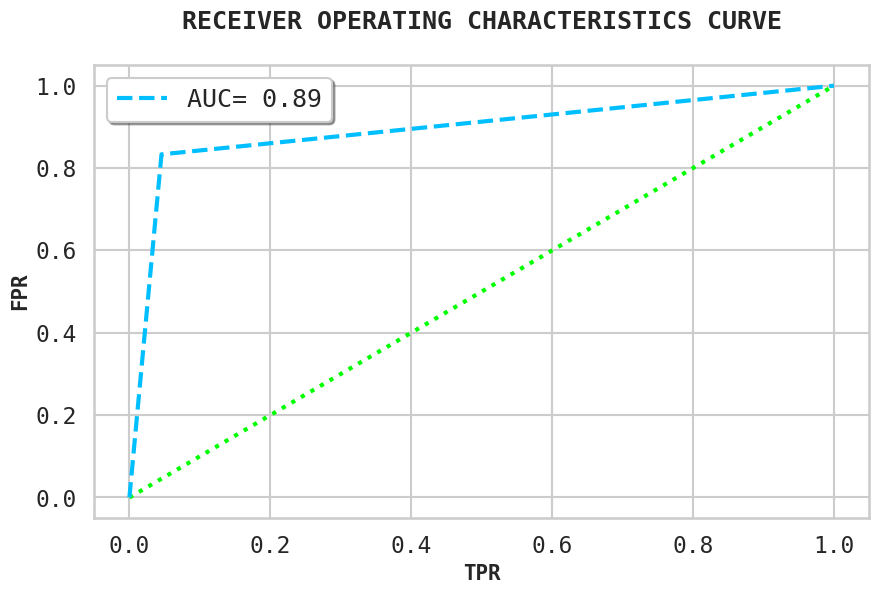



	____________________________________________CONFUSION MATRIX___________________________________________



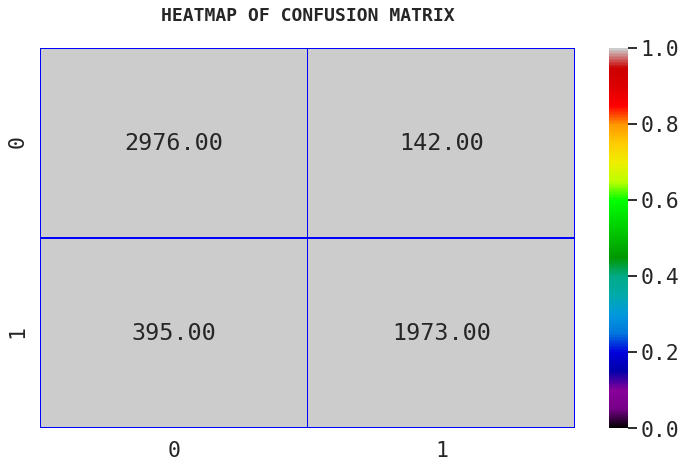

In [44]:
rfc=RandomForestClassifier(n_estimators=350,max_depth=9,criterion='entropy',n_jobs=-1)
acusr(rfc,x,y)

In [45]:
rfc_accuracy=cvs(rfc,x,y,scoring='f1',cv=20)

print('THE ACCURACY SCORE AT RFC MODEL IS=', rfc_accuracy.mean())
CV_ACC.append(rfc_accuracy.mean())

THE ACCURACY SCORE AT RFC MODEL IS= 0.8830809619111728


## RESULT

In [47]:
model=["LOGISTIC",'PASSIVE AGGRESIVE','MULTINOMIAL NB','COMPLEMENT NB','RANDOM FOREST']
results = pd.DataFrame({"MODEL":model,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'TPR':TPR,'FPR':FPR,'LOG_LOSS':LOG_LOSS,"CV_ACCURACY":CV_ACC})
                               
                                
            
results.style.set_properties(**{'background-color':'midnightblue','color': 'lime','border-color': 'darkorange'})                               

,MODEL,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,TPR,FPR,LOG_LOSS,CV_ACCURACY
0,LOGISTIC,0.939079,0.949872,0.944089,0.934122,0.228725,0.052315,0.946054,[0. 0.04201411 1. ],[0. 0.93412162 1. ],1.806915,0.939484
1,PASSIVE AGGRESIVE,0.944806,0.953700,0.939091,0.950591,0.218953,0.047940,0.951883,[0. 0.04682489 1. ],[0. 0.95059122 1. ],1.655818,0.942897
2,MULTINOMIAL NB,0.884462,0.910499,0.929302,0.843750,0.308466,0.095151,0.897500,[0. 0.0487492 1. ],[0. 0.84375 1. ],3.286431,0.881183
3,COMPLEMENT NB,0.893241,0.915057,0.910887,0.876267,0.300686,0.090412,0.905581,[0. 0.06510584 1. ],[0. 0.87626689 1. ],3.122748,0.891144
4,RANDOM FOREST,0.880214,0.915968,0.932861,0.833193,0.312867,0.097886,0.893825,[0. 0.04554201 1. ],[0. 0.83319257 1. ],3.380867,0.883081


## SAVING RESULT

`Basing on the above obsevation PASSIVE AGGRESIVE CLASSIFIER  is working best with an F1 score  of 0.9448 with out cross validation and F1 score of 0.942897 with cross validation  so selcting it as the final model.`

In [48]:
pac

PassiveAggressiveClassifier(max_iter=1200)

In [49]:
joblib.dump(pac,'FAKE_PAC.obj')

['FAKE_PAC.obj']